## Please choose the next options

In [2]:
_DO_GRIDSEARCH_OLD_DATA = False  # whether to perform hyperparameter gridsearch optimization on the old data
_DO_GRIDSEARCH_NEW_DATA = False  # whether to perform hyperparameter gridsearch optimization on the new data

## Installing packages

We will start by installing required packages.

In [3]:
# To write bash code in python jupyter cell, put ! before the command
!pip install biopython
!pip install tensorflow-addons
!pip install gdown

     |████████████████████████████████| 2.3 MB 13.4 MB/s 
     |████████████████████████████████| 1.1 MB 12.5 MB/s 


Let us clone the Github repository of [Zhang et al.](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-020-03864-0) to access the [data](https://github.com/yuuuuzhang/TriplexFPP_data) and the [code](https://github.com/yuuuuzhang/TriplexFPP) (just in case we need them).

In [4]:
!git clone https://github.com/yuuuuzhang/TriplexFPP_data.git  # downloading data
!git clone https://github.com/yuuuuzhang/TriplexFPP.git  # downloading code

Cloning into 'TriplexFPP_data'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 4), reused 5 (delta 1), pack-reused 0
Unpacking objects: 100% (24/24), done.
Cloning into 'TriplexFPP'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 124 (delta 48), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (124/124), 39.61 MiB | 11.81 MiB/s, done.
Resolving deltas: 100% (48/48), done.


Importing the needed packages..

In [5]:
import os
import warnings
warnings.filterwarnings("ignore")

import multiprocessing
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import math
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import losses, optimizers, metrics, layers, models, callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import load_model

from Bio import SeqIO

%matplotlib inline

## Playing with the old negative data...

Now let us get the positive and negative histone modification data.

In [6]:
# Remembering the names of the histone modifications
HM_names = ['H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9me1', 'H3K9me3', 
            'H3K27me3', 'H3K36me3', 'H3K79me2', 'H2A.Z', 'H3K9ac', 
            'H3K27ac', 'H4K20me1']

# Creating a folder for figures
!mkdir -p figs

if not os.path.exists('./negative_data.csv'):
    raise FileNotFoundError('Please put negative_data.csv in the same folder as the jupyter notebook')

if not os.path.exists('./positive_data.csv'):
    raise FileNotFoundError('Please put positive_data.csv in the same folder as the jupyter notebook')

if not os.path.exists('./models.zip'):
        raise FileNotFoundError('Please put models.zip in the same folder as the jupyter notebook')

    
!unzip "./models.zip"  # unzip processed_data.zip
    
# Reading the positive and negative data
pos_data = pd.read_csv(
    'positive_data.csv', sep='\t', header=None, names=HM_names)
neg_data = pd.read_csv(
    'negative_data.csv', sep='\t', header=None, names=HM_names)

# Merging the data into one dataframe, creating the labels array
raw_data = pd.concat([pos_data, neg_data], axis=0)
labels = np.array([1]*len(pos_data) + [0]*len(neg_data))

print(f'Overall, we have {raw_data.shape[0]} DNA regions and {raw_data.shape[1]} features..')
print(f'{pos_data.shape[0]} DNA regions are positive, {neg_data.shape[0]} are negative..')
raw_data.head()

Downloading...
From: https://drive.google.com/uc?id=1tug5b2Vz9LIIJoLOIlzE-0ZNHZFFqCh-
To: /content/negative_data.csv
100% 151k/151k [00:00<00:00, 53.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TzamreBGzUWvdu6bmEs9-mlKTKSv5O58
To: /content/positive_data.csv
100% 128k/128k [00:00<00:00, 72.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1d-XTefCMfjUvYoUf5dBKzq5iEg3SZ_-2
To: /content/models.zip
129MB [00:00, 136MB/s]
Archive:  ./models.zip
   creating: models/
  inflating: models/DNA_LSTM_3.h5    
  inflating: models/DNA_LSTM_2.h5    
  inflating: models/lncRNA_LSTM_1.h5  
  inflating: models/lncRNA_CNN.h5    
  inflating: models/DNA_CNN.h5       
  inflating: models/lncRNA_ResNN.h5  
  inflating: models/DNA_ResNN.h5     
  inflating: models/DNA_LSTM_1.h5    
  inflating: models/lncRNA_LSTM_2.h5  
  inflating: models/lncRNA_LSTM_3.h5  
  inflating: models/best_MLP.h5      
  inflating: models/best_MLP_old.h5  
   creating: models/.ipynb_checkpoints/
  inflating:

H3K4me1  H3K4me2  H3K4me3  ...  H3K9ac  H3K27ac  H4K20me1
chr1 629800  630250         0        0        0  ...       0        0         0
     1312900 1313050        1        0        2  ...       2        1         0
     1477250 1478000        1        7        6  ...       2       11         6
     2026750 2027100        3        2        0  ...       0        3         4
     5481750 5482050        2        0        3  ...       1        0         5

[5 rows x 12 columns]

Let us have a quick outlook on the data.

In [ ]:
raw_data.describe().T

,count,mean,std,min,25%,50%,75%,max
H3K4me1,5561.0,9.392735,21.916701,0.0,1.0,3.0,8.0,423.0
H3K4me2,5561.0,8.316849,36.994180,0.0,1.0,2.0,4.0,738.0
H3K4me3,5561.0,7.591081,28.568157,0.0,1.0,3.0,5.0,688.0
H3K9me1,5561.0,8.319187,11.605494,0.0,3.0,6.0,11.0,272.0
H3K9me3,5561.0,8.649523,15.030867,0.0,3.0,6.0,11.0,375.0
H3K27me3,5561.0,7.025895,11.175451,0.0,2.0,4.0,8.0,244.0
H3K36me3,5561.0,7.115627,13.391831,0.0,1.0,3.0,7.0,272.0
H3K79me2,5561.0,11.406402,45.351889,0.0,1.0,3.0,6.0,961.0
H2A.Z,5561.0,11.170113,28.231969,0.0,2.0,5.0,10.0,479.0
H3K9ac,5561.0,9.812084,39.484859,0.0,2.0,4.0,7.0,1004.0


Let us plot the region length distribution plot.

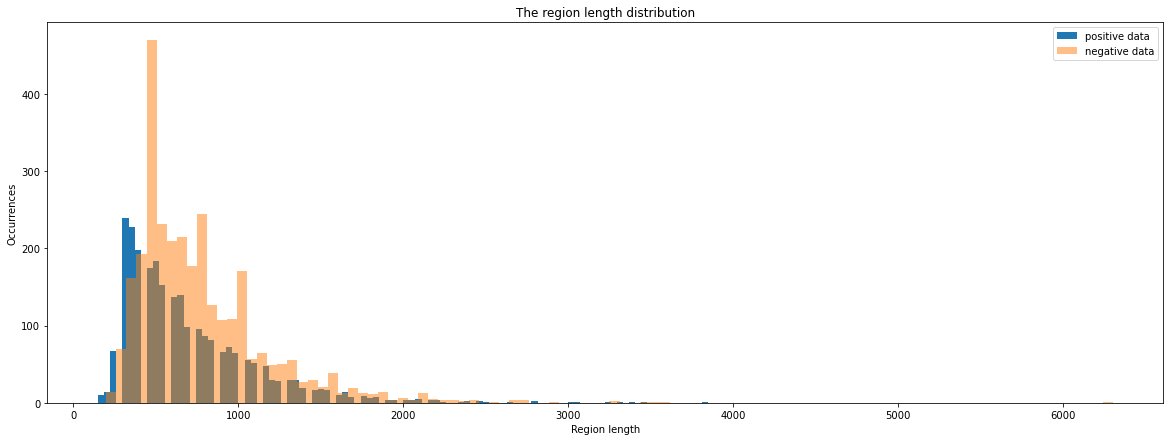

In [ ]:
f, ax = plt.subplots(figsize=(20, 7))
pos_lengths = pos_data.index.get_level_values(2) - pos_data.index.get_level_values(1)
neg_lengths = neg_data.index.get_level_values(2) - neg_data.index.get_level_values(1)
ax.hist(pos_lengths, bins=100, label='positive data')
ax.hist(neg_lengths, bins=100, label='negative data', alpha=0.5)
ax.set_xlabel('Region length')
ax.set_ylabel('Occurrences')
ax.set_title('The region length distribution')
ax.legend();
plt.savefig('./figs/pos_neg_data_len_dist_1.png', dpi=300)

Let us filter out sequences longer than 2000 BPs..

In [ ]:
old_len = len(raw_data)
filtered_data = raw_data.loc[(raw_data.index.get_level_values(2) - raw_data.index.get_level_values(1)) < 2000]
print(f'After filtering we decreased the number of regions from {old_len} to '
      f'{filtered_data.shape[0]}')

After filtering we decreased the number of regions from 5561 to 5473


In [ ]:
# Setting some hyperparams
_DATA_SIZE = len(filtered_data)
_TRAIN_PERCENTAGE = 0.8
_VAL_PERCENTAGE = 0.1
_TEST_PERCENTAGE = 0.1
_TRAIN_SIZE = int(_TRAIN_PERCENTAGE * _DATA_SIZE)
_VAL_SIZE = int(_VAL_PERCENTAGE * _DATA_SIZE)
_TEST_SIZE = int(_TEST_PERCENTAGE * _DATA_SIZE)

# Setting numpy random seed for reproducibility
np.random.seed(42)

# Shuffling the data
data_index = np.arange(_DATA_SIZE)
np.random.shuffle(data_index)
data, labels = filtered_data.iloc[data_index], labels[data_index]

# Scale features for both datasets
scaler = StandardScaler()
scaler.fit(data[:_TRAIN_SIZE])
data = scaler.transform(data)

# Splitting data into train, validation and test as 80%/10%/10%
train_data, train_labels = data[:_TRAIN_SIZE], labels[:_TRAIN_SIZE]
test_data, test_labels = data[_TRAIN_SIZE:], labels[_TRAIN_SIZE:]
val_data, val_labels = test_data[:_VAL_SIZE], test_labels[:_VAL_SIZE]
test_data, test_labels = test_data[_TEST_SIZE:], test_labels[_TEST_SIZE:]

Let us prepare for training and testing..

In [ ]:
# Defining some hyperparameters, as well as metrics and early stopping callback 
# that applies to all models
_EPOCHS = 50
_LEARNING_RATE = 1e-2
_BATCH_SIZE = 32
_VERBOSE = 1

# Setting plotting parameters
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def mcc(y_true, y_pred):
    """
    Courtesy of https://stackoverflow.com/questions/56865344/how-do-i-calculate-the-matthews-correlation-coefficient-in-tensorflow
    """
    predicted = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    true_pos = tf.math.count_nonzero(predicted * y_true)
    true_neg = tf.math.count_nonzero((predicted - 1) * (y_true - 1))
    false_pos = tf.math.count_nonzero(predicted * (y_true - 1))
    false_neg = tf.math.count_nonzero((predicted - 1) * y_true)
    x = tf.cast((true_pos + false_pos) * (true_pos + false_neg) 
        * (true_neg + false_pos) * (true_neg + false_neg), tf.float32)
    return tf.cast((true_pos * true_neg) - (false_pos * false_neg), tf.float32) / tf.sqrt(x)

_METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5),
      mcc
]


def plot_metrics(history, model_name):
    # Courtesy of https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#oversample_the_minority_class
    metrics = ['loss', 'auc', 'precision', 'recall', 'f1_score', 'mcc']
    fig = plt.figure(figsize=(20,7))
    for n, metric in enumerate(metrics):
        if metrics == 'f1_score':
            curr_train_history = np.transpose(np.array(history.history[metric]))[0]
            curr_val_history = np.transpose(np.array(history.history['val_'+metric]))[0]
        else:
            curr_train_history = np.array(history.history[metric])
            curr_val_history = np.array(history.history['val_'+metric])
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2, 3, n+1)
        plt.plot(history.epoch, curr_train_history, color=colors[0], label='Train')
        plt.plot(history.epoch, curr_val_history,
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        filtered_train_history = curr_train_history[~np.isnan(curr_train_history)]
        filtered_val_history = curr_val_history[~np.isnan(curr_val_history)]
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([max(max(filtered_train_history, default=0) - 0.5, 0), 1])

        plt.legend()

    plt.savefig(f'./figs/training_{model_name}.png', dpi=300)

def get_callbacks(model_name, with_early_stopping=True):
    return [callbacks.EarlyStopping(patience=20, restore_best_weights=True,
                                    verbose=_VERBOSE), 
            callbacks.ModelCheckpoint(filepath=f'./models/{model_name}.h5', verbose=_VERBOSE,
                                      save_best_only=True)
            ] if with_early_stopping else \
            [callbacks.ModelCheckpoint(filepath=f'./models/{model_name}.h5', verbose=_VERBOSE,
                                      save_best_only=True)]

### Training and testing CNN based on paper

Now as the data is ready we are ready to build the model and train it.

In [ ]:
MLP = models.Sequential(
    [
    layers.Dense(30, activation='relu', input_shape=(12,), name='dense_1'),
    layers.Dense(60, activation='relu', name='dense_2'),
    layers.Dropout(0.5, name='dropout_1'),
    layers.Dense(60, activation='relu', name='dense_3'),
    layers.Dropout(0.5, name='dropout_2'),
    layers.Dense(30, activation='relu', name='dense_4'),
    layers.Dense(1, activation='sigmoid', name='dense_5'),
], name='MLP')

MLP.compile(optimizer=optimizers.Adam(lr=_LEARNING_RATE),
                loss=losses.BinaryCrossentropy(),
                metrics=_METRICS)
MLP.summary()

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dense_2 (Dense)              (None, 60)                1860      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3660      
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 31      

Now we let us plot the training history.

Epoch 1/50
137/137 [==============================] - 8s 32ms/step - loss: 0.7230 - accuracy: 0.5245 - precision: 0.5070 - recall: 0.3283 - auc: 0.5118 - f1_score: 0.3919 - mcc: nan - val_loss: 0.6872 - val_accuracy: 0.5612 - val_precision: 0.5556 - val_recall: 0.0413 - val_auc: 0.5530 - val_f1_score: 0.0769 - val_mcc: nan

Epoch 00001: val_loss improved from inf to 0.68717, saving model to ./models/MLP.h5
Epoch 2/50
137/137 [==============================] - 3s 20ms/step - loss: 0.6926 - accuracy: 0.5277 - precision: 0.5072 - recall: 0.3546 - auc: 0.5340 - f1_score: 0.4080 - mcc: nan - val_loss: 0.6862 - val_accuracy: 0.5612 - val_precision: 1.0000 - val_recall: 0.0083 - val_auc: 0.5423 - val_f1_score: 0.0164 - val_mcc: nan

Epoch 00002: val_loss improved from 0.68717 to 0.68616, saving model to ./models/MLP.h5
Epoch 3/50
137/137 [==============================] - 3s 21ms/step - loss: 0.6900 - accuracy: 0.5361 - precision: 0.4889 - recall: 0.0214 - auc: 0.5215 - f1_score: 0.0408 - mcc

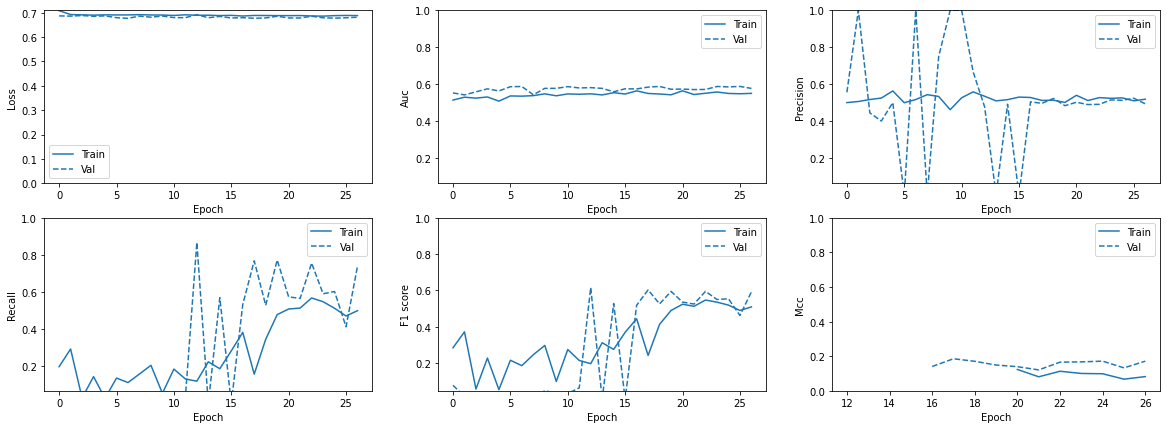

In [ ]:
MLP_training_history = MLP.fit(train_data, train_labels, batch_size=_BATCH_SIZE,
                                epochs=_EPOCHS, validation_data=(val_data, val_labels),
                                verbose=_VERBOSE, callbacks=get_callbacks('MLP'))
plot_metrics(MLP_training_history, 'MLP_1')

Let us now test the model.

In [ ]:
test_evals = MLP.evaluate(test_data, test_labels, verbose=_VERBOSE)
for metrics_name, metrics_value in zip(MLP.metrics_names, test_evals):
    print(f'Test {metrics_name}: {metrics_value}')   

18/18 [==============================] - 0s 13ms/step - loss: 0.6734 - accuracy: 0.5766 - precision: 1.0000 - recall: 0.0128 - auc: 0.5840 - f1_score: 0.0252 - mcc: nan   
Test loss: 0.6733951568603516
Test accuracy: 0.5766423344612122
Test precision: 1.0
Test recall: 0.012765957042574883
Test auc: 0.5840256214141846
Test f1_score: [0.02521008]
Test mcc: nan


We do the same thing for CNNs..

In [ ]:
CNN = models.Sequential(
    [
    layers.Reshape((12, -1), input_shape=(12,)),
    layers.Conv1D(8, 8, activation='relu', name='conv_1'),
    layers.Conv1D(8, 4, activation='relu', name='conv_2'),
    layers.Flatten(name='flatten'),
    layers.Dropout(0.5, name='dropout_1'),
    layers.Dense(100, activation='relu', name='dense_1'),
    layers.Dropout(0.5, name='dropout_2'),
    layers.Dense(1, activation='sigmoid', name='dense_2')
], name='CNN')

CNN.compile(optimizer=optimizers.Adam(lr=_LEARNING_RATE),
                loss=losses.BinaryCrossentropy(),
                metrics=_METRICS)

CNN.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 12, 1)             0         
_________________________________________________________________
conv_1 (Conv1D)              (None, 5, 8)              72        
_________________________________________________________________
conv_2 (Conv1D)              (None, 2, 8)              264       
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1700      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0       

Epoch 1/50
137/137 [==============================] - 8s 28ms/step - loss: 0.6970 - accuracy: 0.5354 - precision: 0.4991 - recall: 0.2330 - auc: 0.5317 - f1_score: 0.3054 - mcc: nan - val_loss: 0.6931 - val_accuracy: 0.5612 - val_precision: 0.5278 - val_recall: 0.0785 - val_auc: 0.5209 - val_f1_score: 0.1367 - val_mcc: nan

Epoch 00001: val_loss improved from inf to 0.69311, saving model to ./models/CNN.h5
Epoch 2/50
137/137 [==============================] - 3s 19ms/step - loss: 0.7001 - accuracy: 0.5227 - precision: 0.4808 - recall: 0.1104 - auc: 0.4736 - f1_score: 0.1762 - mcc: nan - val_loss: 0.6868 - val_accuracy: 0.5631 - val_precision: 0.8000 - val_recall: 0.0165 - val_auc: 0.5100 - val_f1_score: 0.0324 - val_mcc: nan

Epoch 00002: val_loss improved from 0.69311 to 0.68680, saving model to ./models/CNN.h5
Epoch 3/50
137/137 [==============================] - 3s 20ms/step - loss: 0.6921 - accuracy: 0.5256 - precision: 0.5111 - recall: 0.0337 - auc: 0.5039 - f1_score: 0.0610 - mcc

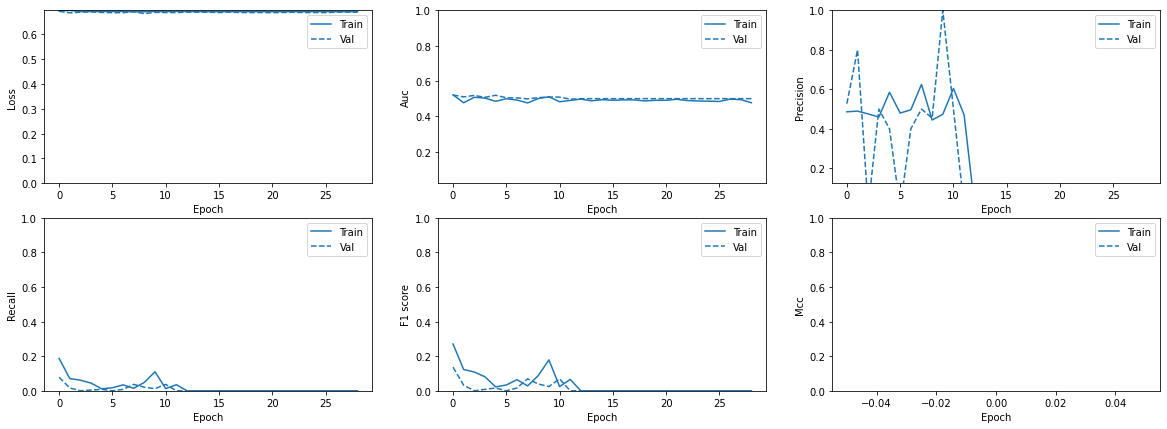

In [ ]:
CNN_training_history = CNN.fit(train_data, train_labels, batch_size=_BATCH_SIZE, 
                               epochs=_EPOCHS, validation_data=(val_data, val_labels),
                               verbose=_VERBOSE, callbacks=get_callbacks('CNN'))
plot_metrics(CNN_training_history, 'CNN_1')

In [ ]:
test_evals = CNN.evaluate(test_data, test_labels, verbose=_VERBOSE)
for metrics_name, metrics_value in zip(CNN.metrics_names, test_evals):
    print(f'Test {metrics_name}: {metrics_value}')   

18/18 [==============================] - 0s 14ms/step - loss: 0.6829 - accuracy: 0.5730 - precision: 0.5556 - recall: 0.0213 - auc: 0.5076 - f1_score: 0.0410 - mcc: nan     
Test loss: 0.6828963160514832
Test accuracy: 0.5729926824569702
Test precision: 0.5555555820465088
Test recall: 0.021276595070958138
Test auc: 0.5076337456703186
Test f1_score: [0.04098361]
Test mcc: nan


Let us try the grid search optimization to find the maximum possible NN performance..

In [ ]:
if _DO_GRIDSEARCH_OLD_DATA:
    X = np.concatenate([train_data, val_data])
    Y = np.concatenate([train_labels, val_labels])

In [ ]:
if _DO_GRIDSEARCH_OLD_DATA:
    def create_MLP(num_hidden_layers, add_dropout, lr, batch_size):
        model = models.Sequential(name='MLP')
        model.add(layers.Dense(30, input_dim=12, activation='relu', name='layer_0'))
        num_inside_layers = num_hidden_layers + int(add_dropout)
        for i in range(num_inside_layers):
            if add_dropout and i == (num_inside_layers // 2):
                model.add(layers.Dropout(0.5, name=f'layer_{i + 1}'))
            else:
                model.add(layers.Dense(50, activation='relu', name=f'layer_{i + 1}'))
        model.add(layers.Dense(1, activation='sigmoid', name='final'))
        model.compile(optimizer=optimizers.Adam(lr=lr), 
                      loss=losses.BinaryCrossentropy(), 
                      metrics=_METRICS)

        return model

    model = KerasClassifier(build_fn=create_MLP, verbose=0)
    # define the grid search parameters
    grid_num_hidden_layers = [2, 3]
    dropouts = [True]
    lrs = [0.0001, 0.001, 0.01, 0.1]
    batch_sizes = [30, 50, 100]
    epochs = [60, 80]
    param_grid = dict(batch_size=batch_sizes, num_hidden_layers=grid_num_hidden_layers, 
                      add_dropout=dropouts, lr=lrs, epochs=epochs)
    grid = GridSearchCV(estimator=model, scoring='roc_auc', param_grid=param_grid, n_jobs=1, cv=3, verbose=2, error_score="raise")
    grid_result = grid.fit(X, Y)
    best_model = grid_result.best_estimator_.model
    best_model.save('models/best_MLP_old.h5')
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print(grid_result.best_estimator_.model.summary())

In [ ]:
best_MLP_old = load_model('models/best_MLP_old.h5', 
                          custom_objects = {
                              'f1_score': tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5),
                              'mcc': mcc
                          })
best_MLP_old.compile(optimizer=optimizers.Adam(lr=_LEARNING_RATE), 
                 loss=losses.BinaryCrossentropy(),
                 metrics=_METRICS)
best_MLP_old.summary()

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_0 (Dense)              (None, 30)                390       
_________________________________________________________________
layer_1 (Dense)              (None, 50)                1550      
_________________________________________________________________
layer_2 (Dropout)            (None, 50)                0         
_________________________________________________________________
layer_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
final (Dense)                (None, 1)                 51        
Total params: 4,541
Trainable params: 4,541
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test_evals = best_MLP_old.evaluate(test_data, test_labels, verbose=_VERBOSE)
for metrics_name, metrics_value in zip(best_MLP_old.metrics_names, test_evals):
    print(f'Test {metrics_name}: {metrics_value}')     

18/18 [==============================] - 2s 13ms/step - loss: 0.6784 - accuracy: 0.5761 - precision: 0.5179 - recall: 0.1218 - auc: 0.5305 - f1_score: 0.1931 - mcc: 0.0913
Test loss: 0.6744797229766846
Test accuracy: 0.5793795585632324
Test precision: 0.5286624431610107
Test recall: 0.1765957474708557
Test auc: 0.5430256128311157
Test f1_score: [0.2647528]
Test mcc: 0.08297319710254669


In [ ]:
if _DO_GRIDSEARCH_OLD_DATA:
    def create_CNN(num_conv_layers, num_hidden_layers, num_out_filters, kernel_size, 
                   add_dropout, lr, batch_size):
        model = models.Sequential(name='CNN')
        model.add(layers.Reshape((12, -1), input_shape=(12,), name='reshape'))
        for i in range(num_conv_layers):
            model.add(
                layers.Conv1D(num_out_filters*(i + 1), kernel_size, 
                              activation='relu', 
                              name=f'layer_{i + 1}'))
        model.add(layers.Flatten(name='flatten')),
        for i in range(num_hidden_layers):
            model.add(layers.Dense(50, activation='relu', name=f'layer_{num_conv_layers + i + 1}'))
        if add_dropout:
            model.add(layers.Dropout(0.5, name='dropout'))
        model.add(layers.Dense(10, activation='relu', name='pre-final'))
        model.add(layers.Dense(1, activation='sigmoid', name='final'))

        model.compile(optimizer=optimizers.Adam(lr=lr), 
                      loss=losses.BinaryCrossentropy(),
                      metrics=_METRICS)
        return model

    model = KerasClassifier(build_fn=create_CNN, verbose=0)
    # define the grid search parameters
    grid_num_conv_layers = [2]
    grid_num_hidden_layers = [1, 2]
    dropouts = [True]
    filter_sizes = [4, 8]
    kernel_sizes = [3, 6]
    lrs = [0.0001, 0.001, 0.01, 0.1]
    batch_sizes = [50, 100]
    epochs = [60, 70]
    param_grid = dict(batch_size=batch_sizes, num_conv_layers=grid_num_conv_layers, num_hidden_layers=grid_num_hidden_layers,
                      add_dropout=dropouts, num_out_filters=filter_sizes, kernel_size=kernel_sizes, lr=lrs, epochs=epochs)
    grid = GridSearchCV(estimator=model, scoring='roc_auc', cv=3, param_grid=param_grid, n_jobs=1, verbose=2, error_score="raise")
    grid_result = grid.fit(X, Y)
    best_model = grid_result.best_estimator_.model
    best_model.save('models/best_CNN_old.h5')
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print(grid_result.best_estimator_.model.summary())

In [ ]:
best_CNN_old = load_model('models/best_CNN_old.h5', 
                          custom_objects = {
                              'f1_score': tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5),
                              'mcc': mcc
                          })
best_CNN_old.compile(optimizer=optimizers.Adam(lr=_LEARNING_RATE), 
                 loss=losses.BinaryCrossentropy(),
                 metrics=_METRICS)
best_CNN_old.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 12, 1)             0         
_________________________________________________________________
layer_1 (Conv1D)             (None, 7, 8)              56        
_________________________________________________________________
layer_2 (Conv1D)             (None, 2, 16)             784       
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
layer_3 (Dense)              (None, 50)                1650      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
pre-final (Dense)            (None, 10)                510     

In [ ]:
test_evals = best_CNN_old.evaluate(test_data, test_labels, verbose=_VERBOSE)
for metrics_name, metrics_value in zip(best_CNN_old.metrics_names, test_evals):
    print(f'Test {metrics_name}: {metrics_value}')     

18/18 [==============================] - 2s 15ms/step - loss: 0.7001 - accuracy: 0.5709 - precision: 0.4993 - recall: 0.2412 - auc: 0.5449 - f1_score: 0.3236 - mcc: 0.0469
Test loss: 0.6892246603965759
Test accuracy: 0.5699513554573059
Test precision: 0.4975247383117676
Test recall: 0.2851063907146454
Test auc: 0.5520056486129761
Test f1_score: [0.3624887]
Test mcc: 0.05476408451795578


Finally let us plot the performance of optimized networks..

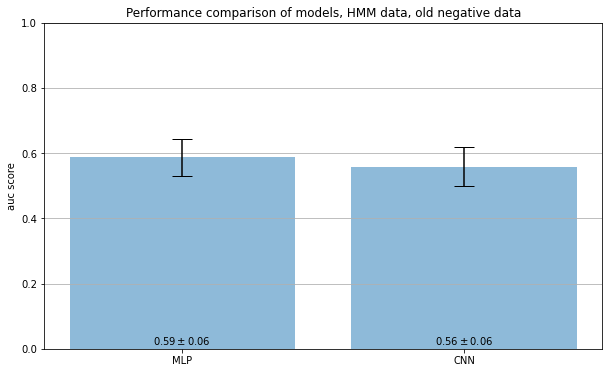

In [ ]:
# Choose the metric to plot
metric_to_plot = 'auc'  # possible options are: accuracy, precision, recall, auc, f1_score, mcc
_BOOTSTRAP_N = 50
_SAMPLES_PER_BOOTSTRAP = 400

def get_bootstrap_statistics(model, test_data, test_labels, metrics, 
                             n_bootstraps, n_samples):
    # This function evaluates the model performance based on bootstrap 
    # statistics
    evals = []
    for _ in range(n_bootstraps):
        sub_data, sub_target = resample(test_data, test_labels, n_samples=n_samples)
        sub_eval = model.evaluate(sub_data, sub_target, verbose=0)
        evals.append(sub_eval[model.metrics_names.index(metrics)])

    return np.mean(evals), np.std(evals) * 2


models_dict = {'MLP': best_MLP_old, 'CNN': best_CNN_old}
model_metrics = {}

# Computing the metric lncRNA models
for model_name, model in models_dict.items():
    model_metrics[model_name] = get_bootstrap_statistics(
        model, test_data, test_labels, metric_to_plot, _BOOTSTRAP_N, 
        _SAMPLES_PER_BOOTSTRAP
    )

f, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.bar(range(len(model_metrics)), 
          [mean for model_name, (mean, _) in model_metrics.items()], 
          yerr=[err for model_name, (_, err) in model_metrics.items()], 
          align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel(f'{metric_to_plot} score')
ax.set_xticks(range(len(model_metrics)))
ax.set_xticklabels([model_name for model_name, _ in model_metrics.items()])
ax.set_title('Performance comparison of models, HMM data, old negative data')
ax.yaxis.grid(True)
ax.set_ylim([0, 1])

# Make some labels.
for bar, (mean, std) in zip(ax.patches, model_metrics.values()):
    ax.annotate(fr'${mean:.2f} \pm {std:.2f}$', 
                   (bar.get_x() + bar.get_width() / 2, 
                    0), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

plt.savefig('./figs/optimized_model_comparison_old.png', dpi=300)

As you may have noticed, the NN training does not go well - the loss does not decrease through the training epochs. One of the reasons to this problem may be the faulty negative data that we used from the original paper. To tackle this issue we decided to adapt the [Zhang et al. 2020](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-020-03864-0) approach, where they used random promoter regions as negative data.

### Playing with the new negative data

We will use [Ensembl](http://www.ensembl.org/index.html) site to obtain the full list of human promoters. Let us load the file from the copy on a Google Drive.

In [8]:
if not os.path.exists('./mart_export.txt'):
    raise FileNotFoundError('Please put mart_export.txt in the same folder as the jupyter notebook')    

promoters = pd.read_csv('mart_export.txt')
print(f'Overall we have {promoters.shape[0]} promoters')
promoters.head()

Downloading...
From: https://drive.google.com/uc?id=1OzNuYy08LoNZqKwK7dqY-Wwp9G70OGH4
To: /content/mart_export.txt.gz
100% 298k/298k [00:00<00:00, 52.2MB/s]
Overall we have 36597 promoters


,Chromosome/scaffold name,Start (bp),End (bp),Feature type
0,19,11557400,11561001,Promoter
1,7,150685000,150688401,Promoter
2,4,64408801,64409600,Promoter
3,7,33107400,33110600,Promoter
4,16,29108800,29109001,Promoter


Let us check the length distribution of available promoters and the positive data regions.

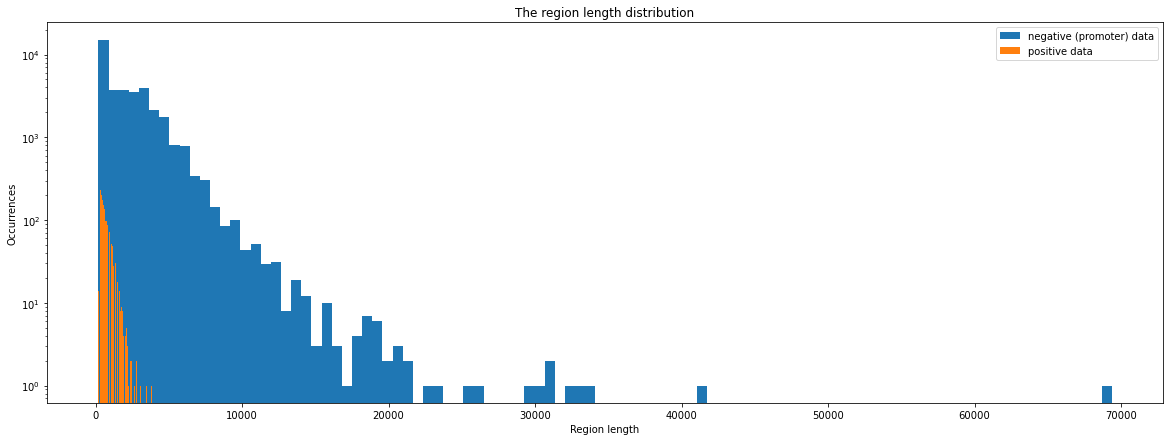

In [ ]:
f, ax = plt.subplots(figsize=(20, 7))
ax.hist((promoters['End (bp)'] - promoters['Start (bp)']), bins=100, label='negative (promoter) data')
lengths = pos_data.index.get_level_values(2) - pos_data.index.get_level_values(1)
ax.hist(lengths, bins=100, label='positive data')
ax.set_xlabel('Region length')
ax.set_ylabel('Occurrences')
ax.set_title('The region length distribution')
plt.yscale('log')
ax.legend();
plt.savefig('./figs/pos_neg_data_len_dist_2.png', dpi=300)

As you may have noticed the length distribution between the negative and positive data is different. To match their lengths, we will filter out too long regions from negative data (> 2000 bp), we also drop all regions from chromosome X (as it was done in [Zhang et al. 2020](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-020-03864-0)). Additionally we will filter out regions that overlap with positive data regions.

The final result will be saved under .bed file which we will use to obtain the ChIP-seq count data, which finally be used as negative data.

In [ ]:
old_len = len(promoters)
filtered_promoters = \
    promoters[lambda x: ((x['End (bp)'] - x['Start (bp)']) < 2000) & (x['Chromosome/scaffold name'] != 'X')]
print(f'After first round of filtering, we decreased number of reginos from {old_len} '
      f'to {filtered_promoters.shape[0]}.')

After first round of filtering, we decreased number of reginos from 36597 to 20275.


The following cell may take some time to compute..

In [ ]:
if False:
    res = []
    for ind, d in tqdm(filtered_promoters.iterrows()):
        flag = False
        for (chr, st, end), d_1 in pos_data.iterrows():
            if st <= d['Start (bp)'] <= end or st <= d['End (bp)'] <= end:
                flag = True
                break
        if not flag:
            res.append(d)
    final_promoters = pd.concat(res, axis=1).T
    final_promoters[['Chromosome/scaffold name', 'Start (bp)', 'End (bp)']] \
        .to_csv('negative.bed', index=False, header=False, sep='\t')

Now we are ready to obtain the ChIP-seq data from the regions saved in negative .csv file. 

In [7]:
if not os.path.exists('./promoter_negative_data.csv'):
    raise FileNotFoundError('Please put promoter_negative_data.csv in the same folder as the jupyter notebook')    

neg_data = pd.read_csv(
    'promoter_negative_data.csv', sep='\t', header=None, names=HM_names)

print(f'Overall we have {neg_data.shape[0]} negative samples.')

Downloading...
From: https://drive.google.com/uc?id=1Hc8QUlpvSlWhErJNdtGrBGDt1MR6Fnpd
To: /content/promoter_negative_data.csv
100% 997k/997k [00:00<00:00, 65.7MB/s]
Overall we have 19800 negative samples.


In [ ]:
neg_data

,,,H3K4me1,H3K4me2,H3K4me3,H3K9me1,H3K9me3,H3K27me3,H3K36me3,H3K79me2,H2A.Z,H3K9ac,H3K27ac,H4K20me1
chr16,29108800,29109001,1,0,0,0,1,5,0,0,4,0,0,2
chr6,158799200,158799601,7,5,3,5,0,4,1,6,3,3,4,7
chr15,31217800,31218001,1,5,0,2,0,3,4,4,4,0,2,7
chr11,72132600,72133201,8,2,3,7,3,1,7,21,4,4,7,10
chr3,185929800,185930201,1,1,2,5,5,6,7,3,12,5,6,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr12,6409801,6410200,1,1,4,4,5,4,1,0,6,4,0,1
chr5,78540200,78540601,12,4,4,10,7,5,8,39,5,6,0,12
chr2,239236200,239236401,0,0,2,1,1,1,6,0,0,0,1,3
chr6,154355000,154355401,3,1,1,2,9,2,3,2,5,0,2,1


We may notice that the amount of negative data is almost 8 times bigger than the amount of positive data. Again, to deal with this disbalance we oversample positive data and undersample negative data. Let us fix the final data size to be 8000.

In [ ]:
_DATA_SIZE = 8000
_TRAIN_PERCENTAGE = 0.8
_VAL_PERCENTAGE = 0.1
_TEST_PERCENTAGE = 0.1
_TRAIN_SIZE = int(_TRAIN_PERCENTAGE * _DATA_SIZE)
_VAL_SIZE = int(_VAL_PERCENTAGE * _DATA_SIZE)
_TEST_SIZE = int(_TEST_PERCENTAGE * _DATA_SIZE)

# Oversampling positive data and undersampling negative data
neg_data_balanced = resample(neg_data, n_samples=_DATA_SIZE // 2)
pos_data_balanced = resample(pos_data, n_samples=_DATA_SIZE // 2)

# Merging the negative and positive data, creating labels array
raw_df = pd.concat([neg_data_balanced, pos_data_balanced], axis=0)
raw_data = raw_df.to_numpy()
labels = np.array([0]*(_DATA_SIZE // 2) + [1]*(_DATA_SIZE // 2))

# Shuffling the data
np.random.seed(42)
data_index = np.arange(_DATA_SIZE)
np.random.shuffle(data_index)
raw_df, raw_data, labels = raw_df.iloc[data_index], raw_data[data_index], labels[data_index]

# Scale features for both datasets
scaler = StandardScaler()
scaler.fit(raw_data[:_TRAIN_SIZE])
data = scaler.transform(raw_data)

# Splitting data into train, validation and test as 80%/10%/10%
train_data, train_labels = data[:_TRAIN_SIZE], labels[:_TRAIN_SIZE]
test_data, test_labels = data[_TRAIN_SIZE:], labels[_TRAIN_SIZE:]
val_data, val_labels = test_data[:_VAL_SIZE], test_labels[:_VAL_SIZE]
test_data, test_labels = test_data[_TEST_SIZE:], test_labels[_TEST_SIZE:]

Now we are ready to train the model. We will again reset the training hyperparameters and the NN architectures.

In [ ]:
# Defining some hyperparameters, as well as metrics and early stopping callback 
# that applies to all models
_EPOCHS = 100
_LEARNING_RATE = 1e-3
_BATCH_SIZE = 32
_VERBOSE = 1

# Setting plotting parameters
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def mcc(y_true, y_pred):
    """
    Courtesy of https://stackoverflow.com/questions/56865344/how-do-i-calculate-the-matthews-correlation-coefficient-in-tensorflow
    """
    predicted = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    true_pos = tf.math.count_nonzero(predicted * y_true)
    true_neg = tf.math.count_nonzero((predicted - 1) * (y_true - 1))
    false_pos = tf.math.count_nonzero(predicted * (y_true - 1))
    false_neg = tf.math.count_nonzero((predicted - 1) * y_true)
    x = tf.cast((true_pos + false_pos) * (true_pos + false_neg) 
        * (true_neg + false_pos) * (true_neg + false_neg), tf.float32)
    return tf.cast((true_pos * true_neg) - (false_pos * false_neg), tf.float32) / tf.sqrt(x)

_METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5),
      mcc
]


def plot_metrics(history, model_name):
    # Courtesy of https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#oversample_the_minority_class
    metrics = ['loss', 'auc', 'precision', 'recall', 'f1_score', 'mcc']
    fig = plt.figure(figsize=(20,7))
    for n, metric in enumerate(metrics):
        if metrics == 'f1_score':
            curr_train_history = np.transpose(np.array(history.history[metric]))[0]
            curr_val_history = np.transpose(np.array(history.history['val_'+metric]))[0]
        else:
            curr_train_history = np.array(history.history[metric])
            curr_val_history = np.array(history.history['val_'+metric])
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2, 3, n+1)
        plt.plot(history.epoch, curr_train_history, color=colors[0], label='Train')
        plt.plot(history.epoch, curr_val_history,
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        filtered_train_history = curr_train_history[~np.isnan(curr_train_history)]
        filtered_val_history = curr_val_history[~np.isnan(curr_val_history)]
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([max(max(filtered_train_history, default=0) - 0.5, 0), 1])

        plt.legend()

    plt.savefig(f'./figs/training_{model_name}.png', dpi=300)


def get_callbacks(model_name, with_early_stopping=True):
    return [callbacks.EarlyStopping(patience=20, restore_best_weights=True,
                                    verbose=_VERBOSE), 
            callbacks.ModelCheckpoint(filepath=f'./models/{model_name}.h5', verbose=_VERBOSE,
                                      save_best_only=True)
            ] if with_early_stopping else \
            [callbacks.ModelCheckpoint(filepath=f'./models/{model_name}.h5', verbose=_VERBOSE,
                                      save_best_only=True)]

In [ ]:
MLP = models.Sequential(
    [
    layers.Dense(30, activation='relu', input_shape=(12,), name='dense_1'),
    layers.Dense(45, activation='relu', name='dense_2'),
    layers.Dense(20, activation='relu', name='dense_3'),
    layers.Dense(1, activation='sigmoid', name='dense_4'),
], name='MLP')

MLP.compile(optimizer=optimizers.Adam(lr=_LEARNING_RATE),
                loss=losses.BinaryCrossentropy(),
                metrics=_METRICS)
MLP.summary()

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dense_2 (Dense)              (None, 45)                1395      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                920       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 2,726
Trainable params: 2,726
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
200/200 [==============================] - 6s 22ms/step - loss: 0.7018 - accuracy: 0.5172 - precision: 0.5222 - recall: 0.4839 - auc: 0.5227 - f1_score: 0.4982 - mcc: 0.0437 - val_loss: 0.6820 - val_accuracy: 0.5863 - val_precision: 0.6016 - val_recall: 0.5648 - val_auc: 0.6040 - val_f1_score: 0.5826 - val_mcc: 0.1765

Epoch 00001: val_loss improved from inf to 0.68203, saving model to ./models/MLP.h5
Epoch 2/100
200/200 [==============================] - 3s 17ms/step - loss: 0.6826 - accuracy: 0.5645 - precision: 0.5670 - recall: 0.5106 - auc: 0.5796 - f1_score: 0.5369 - mcc: 0.1358 - val_loss: 0.6860 - val_accuracy: 0.5612 - val_precision: 0.5863 - val_recall: 0.4817 - val_auc: 0.5865 - val_f1_score: 0.5289 - val_mcc: 0.1303

Epoch 00002: val_loss did not improve from 0.68203
Epoch 3/100
200/200 [==============================] - 3s 16ms/step - loss: 0.6776 - accuracy: 0.5761 - precision: 0.5752 - recall: 0.5372 - auc: 0.5968 - f1_score: 0.5553 - mcc: 0.1592 - val_loss: 0

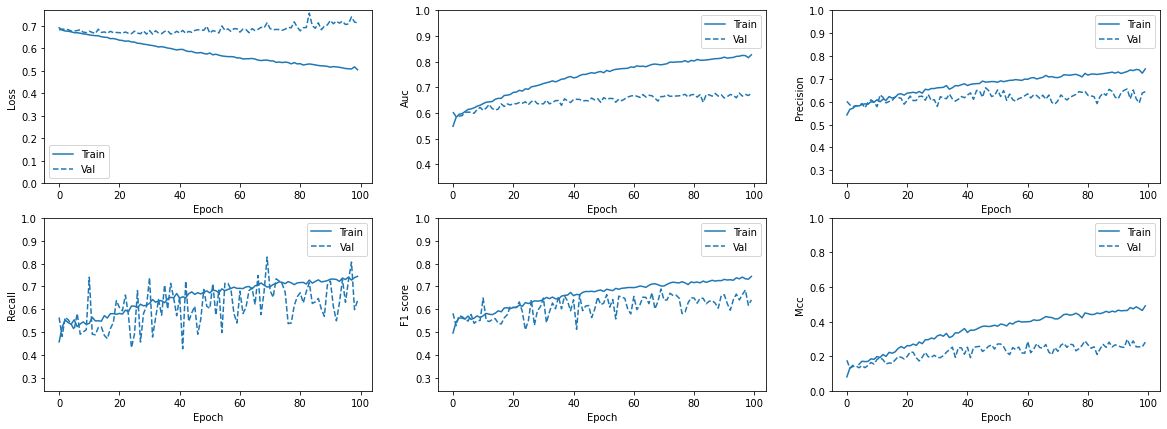

In [ ]:
MLP_training_history = MLP.fit(train_data, train_labels, batch_size=_BATCH_SIZE,
                                epochs=_EPOCHS, validation_data=(val_data, val_labels),
                                verbose=_VERBOSE, callbacks=get_callbacks('MLP', with_early_stopping=False))
plot_metrics(MLP_training_history, 'MLP_2')

In [ ]:
test_evals = MLP.evaluate(test_data, test_labels, verbose=_VERBOSE)
for metrics_name, metrics_value in zip(MLP.metrics_names, test_evals):
    print(f'Test {metrics_name}: {metrics_value}')   

25/25 [==============================] - 0s 12ms/step - loss: 0.7381 - accuracy: 0.6225 - precision: 0.6433 - recall: 0.5668 - auc: 0.6704 - f1_score: 0.6026 - mcc: 0.2497
Test loss: 0.7381463050842285
Test accuracy: 0.6225000023841858
Test precision: 0.6432584524154663
Test recall: 0.5668317079544067
Test auc: 0.6703888773918152
Test f1_score: [0.6026316]
Test mcc: 0.24973666667938232


In [ ]:
CNN = models.Sequential(
    [
    layers.Reshape((12, -1), input_shape=(12,)),
    layers.Conv1D(8, 8, activation='relu', name='conv_1'),
    layers.Conv1D(8, 4, activation='relu', name='conv_2'),
    layers.Flatten(name='flatten'),
    layers.Dense(50, activation='relu', name='dense_1'),
    layers.Dense(50, activation='relu', name='dense_2'),
    layers.Dropout(0.5, name='dropout_1'),
    layers.Dense(10, activation='relu', name='dense_3'),
    layers.Dense(1, activation='sigmoid', name='dense_4')
], name='CNN')

CNN.compile(optimizer=optimizers.Adam(lr=_LEARNING_RATE),
                loss=losses.BinaryCrossentropy(),
                metrics=_METRICS)

CNN.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 12, 1)             0         
_________________________________________________________________
conv_1 (Conv1D)              (None, 5, 8)              72        
_________________________________________________________________
conv_2 (Conv1D)              (None, 2, 8)              264       
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                850       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0       

Epoch 1/100
200/200 [==============================] - 7s 23ms/step - loss: 0.6940 - accuracy: 0.5371 - precision: 0.5344 - recall: 0.6264 - auc: 0.5667 - f1_score: 0.5741 - mcc: nan - val_loss: 0.6938 - val_accuracy: 0.5425 - val_precision: 0.5405 - val_recall: 0.7017 - val_auc: 0.5360 - val_f1_score: 0.6106 - val_mcc: 0.0855

Epoch 00001: val_loss improved from inf to 0.69378, saving model to ./models/CNN.h5
Epoch 2/100
200/200 [==============================] - 4s 19ms/step - loss: 0.6907 - accuracy: 0.5366 - precision: 0.5395 - recall: 0.5385 - auc: 0.5507 - f1_score: 0.5363 - mcc: 0.0770 - val_loss: 0.6880 - val_accuracy: 0.5387 - val_precision: 0.5730 - val_recall: 0.3839 - val_auc: 0.5693 - val_f1_score: 0.4597 - val_mcc: 0.0826

Epoch 00002: val_loss improved from 0.69378 to 0.68800, saving model to ./models/CNN.h5
Epoch 3/100
200/200 [==============================] - 4s 19ms/step - loss: 0.6877 - accuracy: 0.5390 - precision: 0.5460 - recall: 0.4025 - auc: 0.5543 - f1_score: 

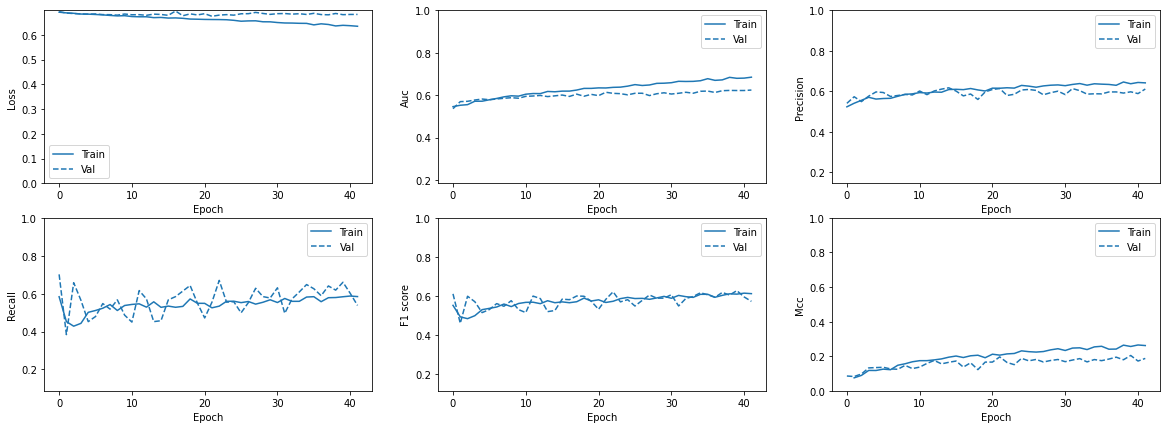

In [ ]:
CNN_training_history = CNN.fit(train_data, train_labels, batch_size=_BATCH_SIZE,
                                        epochs=_EPOCHS, validation_data=(val_data, val_labels),
                                        verbose=_VERBOSE, callbacks=get_callbacks('CNN'))
plot_metrics(CNN_training_history, 'CNN_2')

In [ ]:
test_evals = CNN.evaluate(test_data, test_labels, verbose=_VERBOSE)
for metrics_name, metrics_value in zip(CNN.metrics_names, test_evals):
    print(f'Test {metrics_name}: {metrics_value}')   

25/25 [==============================] - 0s 12ms/step - loss: 0.6810 - accuracy: 0.5537 - precision: 0.5658 - recall: 0.5000 - auc: 0.5754 - f1_score: 0.5309 - mcc: 0.1150
Test loss: 0.68097323179245
Test accuracy: 0.5537499785423279
Test precision: 0.5658263564109802
Test recall: 0.5
Test auc: 0.5753981471061707
Test f1_score: [0.5308804]
Test mcc: 0.11504411697387695


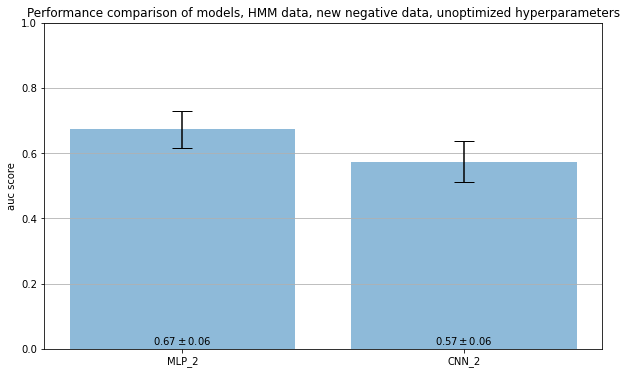

In [ ]:
# Choose the metric to plot
metric_to_plot = 'auc'  # possible options are: accuracy, precision, recall, auc, f1_score, mcc
_BOOTSTRAP_N = 100
_SAMPLES_PER_BOOTSTRAP = 400

def get_bootstrap_statistics(model, test_data, test_labels, metrics, 
                             n_bootstraps, n_samples):
    # This function evaluates the model performance based on bootstrap 
    # statistics
    evals = []
    for _ in range(n_bootstraps):
        sub_data, sub_target = resample(test_data, test_labels, n_samples=n_samples)
        sub_eval = model.evaluate(sub_data, sub_target, verbose=0)
        evals.append(sub_eval[model.metrics_names.index(metrics)])

    return np.mean(evals), np.std(evals) * 2


models_dict = {'MLP_2': MLP, 'CNN_2': CNN}
model_metrics = {}

# Computing the metric lncRNA models
for model_name, model in models_dict.items():
    model_metrics[model_name] = get_bootstrap_statistics(
        model, test_data, test_labels, metric_to_plot, _BOOTSTRAP_N, 
        _SAMPLES_PER_BOOTSTRAP
    )

f, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.bar(range(len(model_metrics)), 
          [mean for model_name, (mean, _) in model_metrics.items()], 
          yerr=[err for model_name, (_, err) in model_metrics.items()], 
          align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel(f'{metric_to_plot} score')
ax.set_xticks(range(len(model_metrics)))
ax.set_xticklabels([model_name for model_name, _ in model_metrics.items()])
ax.set_title('Performance comparison of models, HMM data, new negative data, unoptimized hyperparameters')
ax.yaxis.grid(True)
ax.set_ylim([0, 1])

# Make some labels.
for bar, (mean, std) in zip(ax.patches, model_metrics.values()):
    ax.annotate(fr'${mean:.2f} \pm {std:.2f}$', 
                   (bar.get_x() + bar.get_width() / 2, 
                    0), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.savefig('./figs/bad_model_comparison.png', dpi=300)

Last hope is to optimize the NN training by using a grid of hyperparameters. Let us first disable warnings..

In [ ]:
if _DO_GRIDSEARCH_NEW_DATA:
    X = np.concatenate([train_data, val_data])
    Y = np.concatenate([train_labels, val_labels])

In [ ]:
if _DO_GRIDSEARCH_NEW_DATA:
    def create_MLP(num_hidden_layers, add_dropout, lr, batch_size):
        model = models.Sequential(name='MLP')
        model.add(layers.Dense(30, input_dim=12, activation='relu', name='layer_0'))
        num_inside_layers = num_hidden_layers + int(add_dropout)
        for i in range(num_inside_layers):
            if add_dropout and i == (num_inside_layers // 2):
                model.add(layers.Dropout(0.5, name=f'layer_{i + 1}'))
            else:
                model.add(layers.Dense(50, activation='relu', name=f'layer_{i + 1}'))
        model.add(layers.Dense(1, activation='sigmoid', name='final'))
        model.compile(optimizer=optimizers.Adam(lr=lr), 
                      loss=losses.BinaryCrossentropy(), 
                      metrics=_METRICS)

        return model

    model = KerasClassifier(build_fn=create_MLP, verbose=0)
    # define the grid search parameters
    grid_num_hidden_layers = [1, 2, 3, 4]
    dropouts = [False, True]
    lrs = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
    batch_sizes = [10, 30, 50, 100]
    epochs = [40, 60, 80]
    param_grid = dict(batch_size=batch_sizes, num_hidden_layers=grid_num_hidden_layers, 
                      add_dropout=dropouts, lr=lrs, epochs=epochs)
    grid = GridSearchCV(estimator=model, scoring='roc_auc', param_grid=param_grid, n_jobs=1, cv=3, verbose=2, error_score="raise")
    grid_result = grid.fit(X, Y)
    best_model = grid_result.best_estimator_.model
    best_model.save('models/best_MLP.h5')
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print(grid_result.best_estimator_.model.summary())

In [ ]:
best_MLP = load_model('models/best_MLP.h5', custom_objects = {'f1_score': tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5),
                                                              'mcc': mcc})
best_MLP.compile(optimizer=optimizers.Adam(lr=_LEARNING_RATE), 
                 loss=losses.BinaryCrossentropy(),
                 metrics=_METRICS)
best_MLP.summary()

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_0 (Dense)              (None, 30)                390       
_________________________________________________________________
layer_1 (Dense)              (None, 50)                1550      
_________________________________________________________________
layer_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
layer_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
layer_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
final (Dense)                (None, 1)                 51        
Total params: 9,641
Trainable params: 9,641
Non-trainable params: 0
_____________________________________________________________

In [ ]:
test_evals = best_MLP.evaluate(test_data, test_labels, verbose=_VERBOSE)
for metrics_name, metrics_value in zip(best_MLP.metrics_names, test_evals):
    print(f'Test {metrics_name}: {metrics_value}')     

25/25 [==============================] - 2s 13ms/step - loss: 1.0130 - accuracy: 0.5925 - precision: 0.5949 - recall: 0.5414 - auc: 0.6291 - f1_score: 0.5667 - mcc: 0.2911
Test loss: 1.0462446212768555
Test accuracy: 0.6033333539962769
Test precision: 0.6062718033790588
Test recall: 0.5819398164749146
Test auc: 0.6445891261100769
Test f1_score: [0.59385663]
Test mcc: 0.2584535479545593


In [ ]:
if _DO_GRIDSEARCH_NEW_DATA:
    def create_CNN(num_conv_layers, num_hidden_layers, num_out_filters, kernel_size, 
                   add_dropout, lr, batch_size):
        model = models.Sequential(name='CNN')
        model.add(layers.Reshape((12, -1), input_shape=(12,), name='reshape'))
        for i in range(num_conv_layers):
            model.add(
                layers.Conv1D(num_out_filters*(i + 1), kernel_size, 
                              activation='relu', 
                              name=f'layer_{i + 1}'))
        model.add(layers.Flatten(name='flatten')),
        for i in range(num_hidden_layers):
            model.add(layers.Dense(50, activation='relu', name=f'layer_{num_conv_layers + i + 1}'))
        if add_dropout:
            model.add(layers.Dropout(0.5, name='dropout'))
        model.add(layers.Dense(10, activation='relu', name='pre-final'))
        model.add(layers.Dense(1, activation='sigmoid', name='final'))

        model.compile(optimizer=optimizers.Adam(lr=lr), 
                      loss=losses.BinaryCrossentropy(),
                      metrics=_METRICS)
        return model

    model = KerasClassifier(build_fn=create_CNN, verbose=0)
    # define the grid search parameters
    grid_num_conv_layers = [1, 2]
    grid_num_hidden_layers = [1, 2]
    dropouts = [True]
    filter_sizes = [4, 8, 12]
    kernel_sizes = [3, 6]
    lrs = [0.0001, 0.001, 0.01, 0.1]
    batch_sizes = [30, 50, 100]
    epochs = [30, 60, 80]
    param_grid = dict(batch_size=batch_sizes, num_conv_layers=grid_num_conv_layers, num_hidden_layers=grid_num_hidden_layers,
                      add_dropout=dropouts, num_out_filters=filter_sizes, kernel_size=kernel_sizes, lr=lrs, epochs=epochs)
    grid = GridSearchCV(estimator=model, scoring='roc_auc', cv=3, param_grid=param_grid, n_jobs=1, verbose=2, error_score="raise")
    grid_result = grid.fit(X, Y)
    best_model = grid_result.best_estimator_.model
    best_model.save('models/best_CNN.h5')
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    print(grid_result.best_estimator_.model.summary())

In [ ]:
best_CNN = load_model('models/best_CNN.h5', custom_objects = {'f1_score': tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5),
                                                              'mcc': mcc})
best_CNN.compile(optimizer=optimizers.Adam(lr=_LEARNING_RATE), 
                 loss=losses.BinaryCrossentropy(),
                 metrics=_METRICS)
best_CNN.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 12, 1)             0         
_________________________________________________________________
layer_1 (Conv1D)             (None, 10, 8)             32        
_________________________________________________________________
layer_2 (Conv1D)             (None, 8, 16)             400       
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
layer_3 (Dense)              (None, 50)                6450      
_________________________________________________________________
layer_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0       

In [ ]:
test_evals = best_CNN.evaluate(test_data, test_labels, verbose=_VERBOSE)
for metrics_name, metrics_value in zip(best_CNN.metrics_names, test_evals):
    print(f'Test {metrics_name}: {metrics_value}')     

25/25 [==============================] - 2s 13ms/step - loss: 0.8360 - accuracy: 0.6148 - precision: 0.6187 - recall: 0.5957 - auc: 0.6668 - f1_score: 0.6070 - mcc: 0.2993
Test loss: 0.8772416710853577
Test accuracy: 0.6194999814033508
Test precision: 0.6251298189163208
Test recall: 0.6007984280586243
Test auc: 0.6774947643280029
Test f1_score: [0.61272264]
Test mcc: 0.2885262668132782


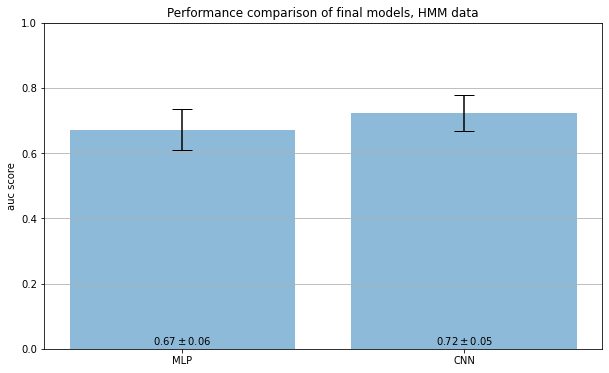

In [ ]:
# Choose the metric to plot
metric_to_plot = 'auc'  # possible options are: accuracy, precision, recall, auc, f1_score, mcc
_BOOTSTRAP_N = 100
_SAMPLES_PER_BOOTSTRAP = 400

def get_bootstrap_statistics(model, test_data, test_labels, metrics, 
                             n_bootstraps, n_samples):
    # This function evaluates the model performance based on bootstrap 
    # statistics
    evals = []
    for _ in range(n_bootstraps):
        sub_data, sub_target = resample(test_data, test_labels, n_samples=n_samples)
        sub_eval = model.evaluate(sub_data, sub_target, verbose=0)
        evals.append(sub_eval[model.metrics_names.index(metrics)])

    return np.mean(evals), np.std(evals) * 2


models_dict = {'MLP': best_MLP, 'CNN': best_CNN}
model_metrics = {}

# Computing the metric lncRNA models
for model_name, model in models_dict.items():
    model_metrics[model_name] = get_bootstrap_statistics(
        model, test_data, test_labels, metric_to_plot, _BOOTSTRAP_N, 
        _SAMPLES_PER_BOOTSTRAP
    )

f, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.bar(range(len(model_metrics)), 
          [mean for model_name, (mean, _) in model_metrics.items()], 
          yerr=[err for model_name, (_, err) in model_metrics.items()], 
          align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel(f'{metric_to_plot} score')
ax.set_xticks(range(len(model_metrics)))
ax.set_xticklabels([model_name for model_name, _ in model_metrics.items()])
ax.set_title('Performance comparison of final models, HMM data')
ax.yaxis.grid(True)
ax.set_ylim([0, 1])

# Make some labels.
for bar, (mean, std) in zip(ax.patches, model_metrics.values()):
    ax.annotate(fr'${mean:.2f} \pm {std:.2f}$', 
                   (bar.get_x() + bar.get_width() / 2, 
                    0), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

plt.savefig('./figs/optimized_model_comparison.png', dpi=300)

In [ ]:
# Generate a random index 0 <= random_sample_index <= 8000
random_sample_index = np.random.randint(_DATA_SIZE)

# Get the features - fetch them from data, expand the row to the matrix,
# then scale the matrix, then add additional axis to pass as an input to NN
random_sample_features = np.expand_dims(data[random_sample_index], axis=0)
random_sample_features_scaled = scaler.transform(random_sample_features)

# Fetch the label for the random sample and the sequence of this sample
random_sample_label = labels[random_sample_index]
random_sample_seq = raw_df.iloc[random_sample_index]

# Get prediction from the NN
CNN_random_sample_prediction = best_CNN.predict(random_sample_features_scaled)
MLP_random_sample_prediction = best_MLP.predict(random_sample_features_scaled)

print('CNN:')
print(f'Fetched a random sample with index={random_sample_index}')
print(f'The HMM features for this sample are:\n{random_sample_seq}')
print(f'The known label for the sample is {random_sample_label}')
print(f'The prediction of the NN is {CNN_random_sample_prediction[0][0]}')

print('\nMLP:')
print(f'Fetched a random sample with index={random_sample_index}')
print(f'The HMM features for this sample are:\n{random_sample_seq}')
print(f'The known label for the sample is {random_sample_label}')
print(f'The prediction of the NN is {MLP_random_sample_prediction[0][0]}')

CNN:
Fetched a random sample with index=595
The HMM features for this sample are:
H3K4me1      0
H3K4me2      1
H3K4me3      1
H3K9me1      6
H3K9me3      2
H3K27me3    14
H3K36me3     2
H3K79me2     0
H2A.Z        2
H3K9ac       3
H3K27ac      0
H4K20me1    11
Name: (chr5, 2175850, 2176250), dtype: int64
The known label for the sample is 1
The prediction of the NN is 0.5462335348129272

MLP:
Fetched a random sample with index=595
The HMM features for this sample are:
H3K4me1      0
H3K4me2      1
H3K4me3      1
H3K9me1      6
H3K9me3      2
H3K27me3    14
H3K36me3     2
H3K79me2     0
H2A.Z        2
H3K9ac       3
H3K27ac      0
H4K20me1    11
Name: (chr5, 2175850, 2176250), dtype: int64
The known label for the sample is 1
The prediction of the NN is 0.5951220989227295
